In [1]:
import pandas as pd
import random as rnd
from networkx import DiGraph
import networkx as nx
%matplotlib inline
import numpy as np
import sys
import matplotlib.pyplot as plt

In [2]:
#load the social graph
#this is a sample of the total data. the entire graph can be found in the "data" folder
edgelist=pd.read_csv('./filtered.csv')
#the format of the data is an edge list: every row has two nodes/vertices that idicate the edge that exist between them
#the graph here is assumed to be directededgelist=pd.read_csv('./filtered.csv')
edgelist.head(5)

,source,target
0,1,3
1,1,4
2,1,5
3,1,6
4,1,7


In [3]:
#load the graph of ACTIONS we care about the action of re-tweet
actions=pd.read_csv('./data/higgs-activity_time.txt',sep=' ')

print(actions.head(5))

#give names to the columns of the data
actions.columns=['from','to','timestamp','action']
#keep only the re-tweet actions : select the rows of the dataframe where action==RT
actions=actions[actions['action']=='RT']
actions=actions[['from','to']].drop_duplicates()
# the set of ids that belong in the action graph ...will be needed later
hasRT=set(actions['from']) | set(actions['to'])

   223789  213163  1341100972  MT
0  223789  213163  1341100972  RE
1  376989   50329  1341101181  RT
2   26375  168366  1341101183  MT
3  376989   13813  1341101192  RT
4  453850       8  1341101208  RT


In [4]:
#buid the graphs from the edge lists
A=DiGraph()
A.add_edges_from(actions.values)
S=DiGraph()
S.add_edges_from(edgelist.values)

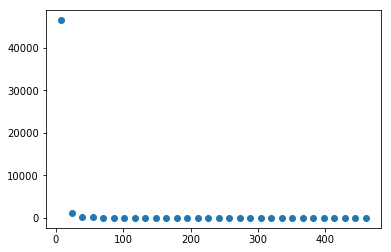

In [5]:
#Get all in-degrees to provide histogra,
in_degree=S.in_degree()
plt.figure()
#plt.hist([in_degree[k] for k in in_degree],bins=30) #bar chart histogram
frequency,bins=np.histogram( #numpy based histogram
    [in_degree[k] for k in in_degree],bins=30)
plt.scatter([(x+bins[i+1])/2.0 for i,x in enumerate(bins[:-1])],frequency)
#these two normally change the scales of the axes  whether they actually work depends (lib version)
#plt.xscale('log')
#plt.yscale('log')

In [6]:
#evaluate the influence of a node by calculating all the nodes that have been influenced by that node
#'B' "beeing influenced" by 'B': at some point the messages of a node A where re-tweeted by Node B 
#i.e. follow the re-tweets in reverse order to see all of those who retweed the "root"
nodes=set(edgelist['source']) & set(edgelist['target'])
influence={}
for node in nodes:
    if node in hasRT:
        #we use bfs in "reverse" to bind all possible retweets that originated at 'node'  
        influence[node]=len(list(nx.bfs_edges(A,node,reverse=True)))

In [11]:
print(influence)

{2: 0, 3: 0, 4: 117, 5: 28, 6: 84, 7: 18, 8: 75462, 9: 0, 10: 0, 11: 0, 13: 3, 14: 0, 15: 75538, 16: 25, 17: 3, 18: 0, 19: 74813, 20: 0, 23: 22, 24: 62, 25: 0, 26: 74819, 27: 52, 28: 15, 30: 0, 31: 0, 34: 37, 36: 0, 37: 0, 38: 2, 39: 7, 40: 121, 42: 215, 43: 74886, 44: 56, 45: 218, 46: 0, 47: 1, 48: 1, 49: 1, 50: 18, 51: 74944, 52: 5, 53: 7, 54: 0, 55: 2, 56: 13, 57: 28, 58: 0, 59: 503, 61: 0, 62: 20, 63: 64, 65: 75029, 66: 3, 67: 2, 68: 74729, 69: 2, 70: 0, 71: 75018, 72: 6, 73: 10, 74: 0, 76: 74730, 77: 75155, 78: 74798, 79: 14, 80: 74767, 81: 74721, 83: 16, 84: 74748, 85: 1, 86: 247, 88: 74721, 89: 17, 90: 1, 91: 92, 92: 62, 93: 17, 94: 74843, 95: 9, 96: 5, 97: 0, 99: 6, 101: 0, 102: 0, 103: 0, 104: 4, 106: 919, 107: 1, 108: 5, 110: 0, 113: 0, 114: 9, 115: 0, 116: 1, 117: 0, 119: 0, 120: 0, 8313: 0, 121: 0, 122: 0, 124: 33, 126: 0, 128: 1, 130: 0, 131: 0, 133: 0, 134: 4, 136: 0, 137: 6, 138: 75972, 140: 6, 141: 1, 142: 8, 143: 74822, 145: 9, 146: 1, 147: 0, 148: 0, 149: 0, 151: 2, 1

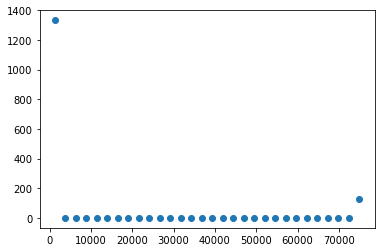

In [13]:
# Plot Influence
plt.figure()
#plt.hist([in_degree[k] for k in in_degree],bins=30) #bar chart histogram
frequency,bins=np.histogram( #numpy based histogram
    [influence[k] for k in influence],bins=30)
plt.scatter([(x+bins[i+1])/2.0 for i,x in enumerate(bins[:-1])],frequency)

In [40]:
# the k-core decomposition algorithm
# calculates the core number for every node:
# core number of  a node is the maximum core that a specific node can be found
def core_numbers(Graph):
    core_n={} #dictionary to hold the k-core index
    i=1 #every node will have at least one neighbor in our case
    G=Graph.copy()
    while G.number_of_nodes()>0: #while the graph is not empty
        NN=G.number_of_nodes() #count how many nodes
        to_remove=[]
        degrees = dict(G.degree())
        for n in G.nodes_iter():
            if degrees[n]<i:
                core_n[n]=i-1
                to_remove.append(n)
        G.remove_nodes_from(to_remove)
        #if the graph size did not change then all nodes have at least k connections
        #increase k 
        if NN==G.number_of_nodes():
            i+=1
    return core_n

In [41]:
# get the core numbers of all nodes
core_num = core_numbers(S)
#print(core_num)

In [42]:
# join core_num and influence
data = []
for node in influence:
    if node in core_num:
        data.append([influence[node], core_num[node], in_degree[node]])
        
df = pd.DataFrame(data, columns=["influence", "core_number", "degree"])

df.head(5)

,influence,core_number,degree
0,0,55,301
1,0,40,33
2,117,55,441
3,28,55,188
4,84,55,468


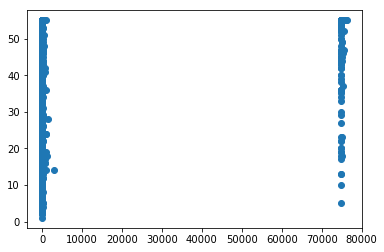

In [43]:
#plt.scatter(df["influence"].apply(np.log), df["core_number"])
plt.figure()
plt.scatter(df["influence"], df["core_number"])

Number of cores 55


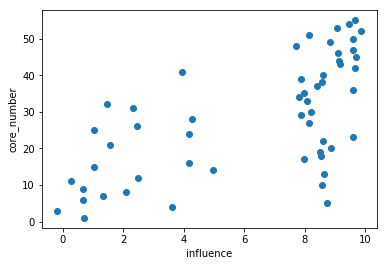

In [50]:
# collect core number and includence evaluations per node
plt.figure()
aggregated_df = df.groupby("core_number").mean().reset_index()
count_cores = aggregated_df.shape[0]
print("Number of cores " + str(count_cores))
#plt.scatter(aggregated_df["influence"], aggregated_df["core_number"])
plt.xlabel('influence')
plt.ylabel('core_number')
plt.scatter(aggregated_df["influence"].apply(np.log), aggregated_df["core_number"])

In [54]:
# you can do the same for any other metric e.g. pagerank

# Get page rank for graph S
pr = nx.pagerank(S)

data = []
for node in influence:
    if node in core_num:
        data.append([influence[node], pr[node], in_degree[node]])
        
df = pd.DataFrame(data, columns=["influence", "page_rank", "degree"])

df.head(5)

,influence,page_rank,degree
0,0,0.000104,301
1,0,0.000031,33
2,117,0.000109,441
3,28,0.000057,188
4,84,0.000161,468


(0, 0.00018799999999999999)

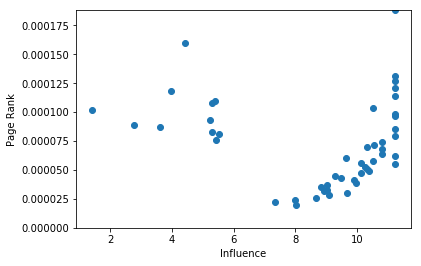

In [76]:
bins = np.linspace(0,df["page_rank"].max(), 100)
labels = [np.round((bins[i] +  bins[i+1])/2, 6) for i in range(len(bins) - 1)]
df['pr_b'] = pd.cut(df["page_rank"], bins, labels=labels)

df2 = df.groupby('pr_b').mean().reset_index()
plt.figure()
plt.xlabel("Influence")
plt.ylabel("Page Rank")
plt.scatter(df2["influence"].apply(np.log), df2["pr_b"])
#plt.ylim([0.00001,0.0002])
plt.ylim([0,df2["pr_b"].max()])


In [ ]:
# plot  core number vs influence to see possible correlation
# get the average "influence" per core number

/Users/aymenmouelhi/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/aymenmouelhi/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/aymenmouelhi/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/aymenmouelhi/anaconda/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  wa

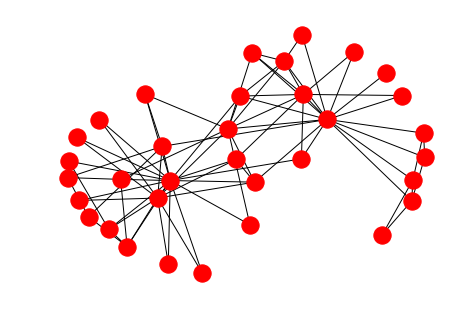

In [77]:
# spring layout is an algorithm to position nodes when we plot them
from networkx import spring_layout
f=open('karate.csv')#we use a smaller graph here : zachary's karate club
edges=[]
for line in f:
        if line[0]!='%':
            tmp=line.strip().split()
            edges.append([int(tmp[0])-1,int(tmp[1])-1])
# build the graph from the edges
K=nx.Graph()
K.add_edges_from(edges)
# plot the graph
nx.draw(K,pos=spring_layout(K))

In [ ]:
# NEXT: SPECTRAL CLUSTERING
# get adjacency matrix
# normalize adjacency matrix: 1/degree of node
# put the degrees in a diagonal matrix
# compute the laplacian = diagonal-adjacency
# we could use only the second eigen vector (positions start at 0)
# the first eigenvector should not have important information
# i.e. the values in the first eigenvector should be almost equal

In [ ]:
from sklearn.cluster import KMeans
# cluster the eigenvector values

# use cluster labels (numerical labels) as color assigment to replot the graph
# nx.draw(K,pos=spring_layout(K), node_color=cluster_assingment)

In [ ]:
# for every clsuter calculate the modularity and aggregate it to one sum
# make a change to the cluster assigments
# re-evaluate modularity